# GPT from Scratch: A Step-by-Step Implementation

This notebook provides a clear and organized implementation of a simplified GPT (Generative Pre-trained Transformer) model from scratch using PyTorch. The goal is to understand the core components and mechanisms behind transformer-based language models by building one in a modular and educational manner.

## Overview

1. **Data Preparation**
   - Load raw text data from an online source.
   - Implement a simple tokenizer to convert text into tokens with special tokens for unknown words, beginning/end of sequence, and padding.
   - Create a custom data loader to generate training batches with sliding windows over token sequences.

2. **Core Components**
   - Define token embeddings and positional embeddings to represent input tokens in vector space.
   - Implement masked multi-head self-attention to allow the model to attend to previous tokens only (causal masking).
   - Build essential building blocks such as Layer Normalization, GELU activation, and Feedforward networks.

3. **Transformer Block**
   - Combine multi-head attention and feedforward layers with residual connections and dropout for regularization.
   - Stack these components to form a single transformer block.

4. **GPT Model Architecture**
   - Assemble embedding layers, transformer block, normalization, and output projection into a complete GPT model.
   - The model predicts the next token in a sequence, enabling language modeling and text generation.

## Configuration

- Context window size: 5 tokens
- Embedding dimension: 100
- Batch size: 8
- Stride for sliding window: 4 tokens
- Number of attention heads: 4
- Dropout rate: 0.1

## Purpose

This notebook aims to demystify the inner workings of GPT models by implementing each component from the ground up. It serves as an educational resource for understanding transformer architectures, attention mechanisms, and language modeling techniques without relying on high-level libraries or pretrained models.

# Load dependencies

In [1]:
import requests
import re
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
cfg = {
    "context_size": 5,
    "vector_dimension": 100,
    "batch_size": 8,
    "stride": 4,
    "num_heads_per_attention_layer": 4,
    "drop_rate": 0.1
}

# 1. Data Preparation

## 1.1. Load the data

In [3]:
# URL of the plain text file
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

In [4]:
response = requests.get(url)
text = response.text
text = text.lstrip('\ufeff')   # This will remove the Byte Order Mark (BOM) as "\ufeff"

print("The number of characters:",len(text))
print(text[:500])

The number of characters: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)

"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it'


## 1.2. Tokenize the data

In [5]:
class SimpleTokenizer:
  def __init__(self, text):

    tokens = self.__tokenize(text)
    all_words = sorted(set(tokens))

    # Adding Special Tokens
    # - <UNK> -> Handling out-of-vocabulary words
    # - (BOS) -> Put in begenning of each document
    # - (EOS) -> Put in end of each document
    # - Padding (BAD) -> Handling unequal sentences in length
    all_words.extend(('<UNK>','<BOS>','<EOS>','<PAD>'))

    self.voc_str_int = {word: i for i, word in enumerate(all_words)}
    self.voc_int_str = {i: word for i, word in enumerate(all_words)}

  def __tokenize(self, text):

    tokens = re.split(r'([,.?_!"()\':;]|--|\s)', text)

    tokens = [token.strip() for token in tokens if token.strip()]

    return tokens

  def encode(self, text):

    tokens = self.__tokenize(text)

    ids = [self.voc_str_int.get(token, self.voc_str_int['<UNK>']) for token in tokens]

    return ids

  def decode(self, ids):

    tokens = [self.voc_int_str.get(id, '<UNK>') for id in ids]

    text = ' '.join(tokens)

    text = re.sub(r'\s+([,.?_!"()\':;]|--|\s)', r'\1', text) # Remove spaces before this specified characters (eg. ,.?)

    return text

  def __len__(self):
    return len(self.voc_str_int)

## 1.3. Data Loader

In [6]:
class SimpleDataLoader:
  def __init__(self, token_ids, context_size=4, batch_size=1, stride=1):
    self.context_size = context_size
    self.batch_size = batch_size
    self.stride = stride

    self.X, self.Y = self.__create_dataset(token_ids)

  def __create_dataset(self, token_ids):
    X, Y = [], []
    for i in range(0, len(token_ids) - self.context_size - 1, self.stride):
      x = token_ids[i : i + self.context_size]
      y = token_ids[i + 1 : i + self.context_size + 1]

      if len(y) == self.context_size:
        X.append(x)
        Y.append(y)

    return torch.tensor(X, dtype=torch.long), torch.tensor(Y, dtype=torch.long)

  def __len__(self):
    return len(self.X) // self.batch_size

  def __getitem__(self, idx):
    start = idx * self.batch_size
    end = start + self.batch_size
    return self.X[start:end], self.Y[start:end]

## 1.4. Tokenize text

In [7]:
# Create Tokenizer
tokenizer = SimpleTokenizer(text)
token_ids = tokenizer.encode(text)
cfg['vocabulary_size'] = len(tokenizer)

# Data Loader
dataloader = SimpleDataLoader(token_ids, cfg["context_size"], cfg["batch_size"], cfg["stride"])
x_batch, y_batch = dataloader[0]

print("X:", x_batch[0])
print("Y:", y_batch[0])

X: tensor([  53,   44,  149, 1003,   57])
Y: tensor([  44,  149, 1003,   57,   38])
tensor([[ 9.9351e-01,  4.5275e-01, -7.7281e-01,  7.9278e-02, -3.5365e-01,
          2.2079e-01, -7.9716e-03, -5.6478e-01,  5.6985e-01, -7.3741e-01,
          5.9448e-02, -6.2778e-01,  8.8198e-01, -7.0161e-01,  1.5426e+00,
         -1.5062e+00, -9.5156e-02,  5.2275e-01,  1.4303e+00, -5.6476e-01,
          8.6324e-01, -1.6899e+00,  3.6880e-01,  4.0763e-01,  5.7234e-01,
         -3.5226e-01,  2.7444e+00,  2.0846e+00, -1.0151e+00,  9.1293e-01,
          1.8304e-02,  6.2693e-01,  3.4268e-01, -7.4990e-01,  5.6384e-01,
         -1.4812e+00,  1.6075e-01, -1.0500e+00, -8.7356e-01,  7.9353e-01,
         -1.6197e+00,  8.5565e-01,  4.1738e-01, -2.8770e-01, -9.8833e-01,
         -3.1473e-01, -1.0641e+00,  3.0188e-01,  1.2679e+00, -8.8391e-01,
          1.0564e+00, -2.3193e-01,  5.6727e-01,  6.3075e-01,  1.1085e+00,
          2.5163e-01, -7.3937e-01, -6.2978e-01, -8.3097e-01,  4.1803e-01,
          4.0996e-01,  1.115

# 2. Masked multi-head attention by weights splits with query, key, and value matrices

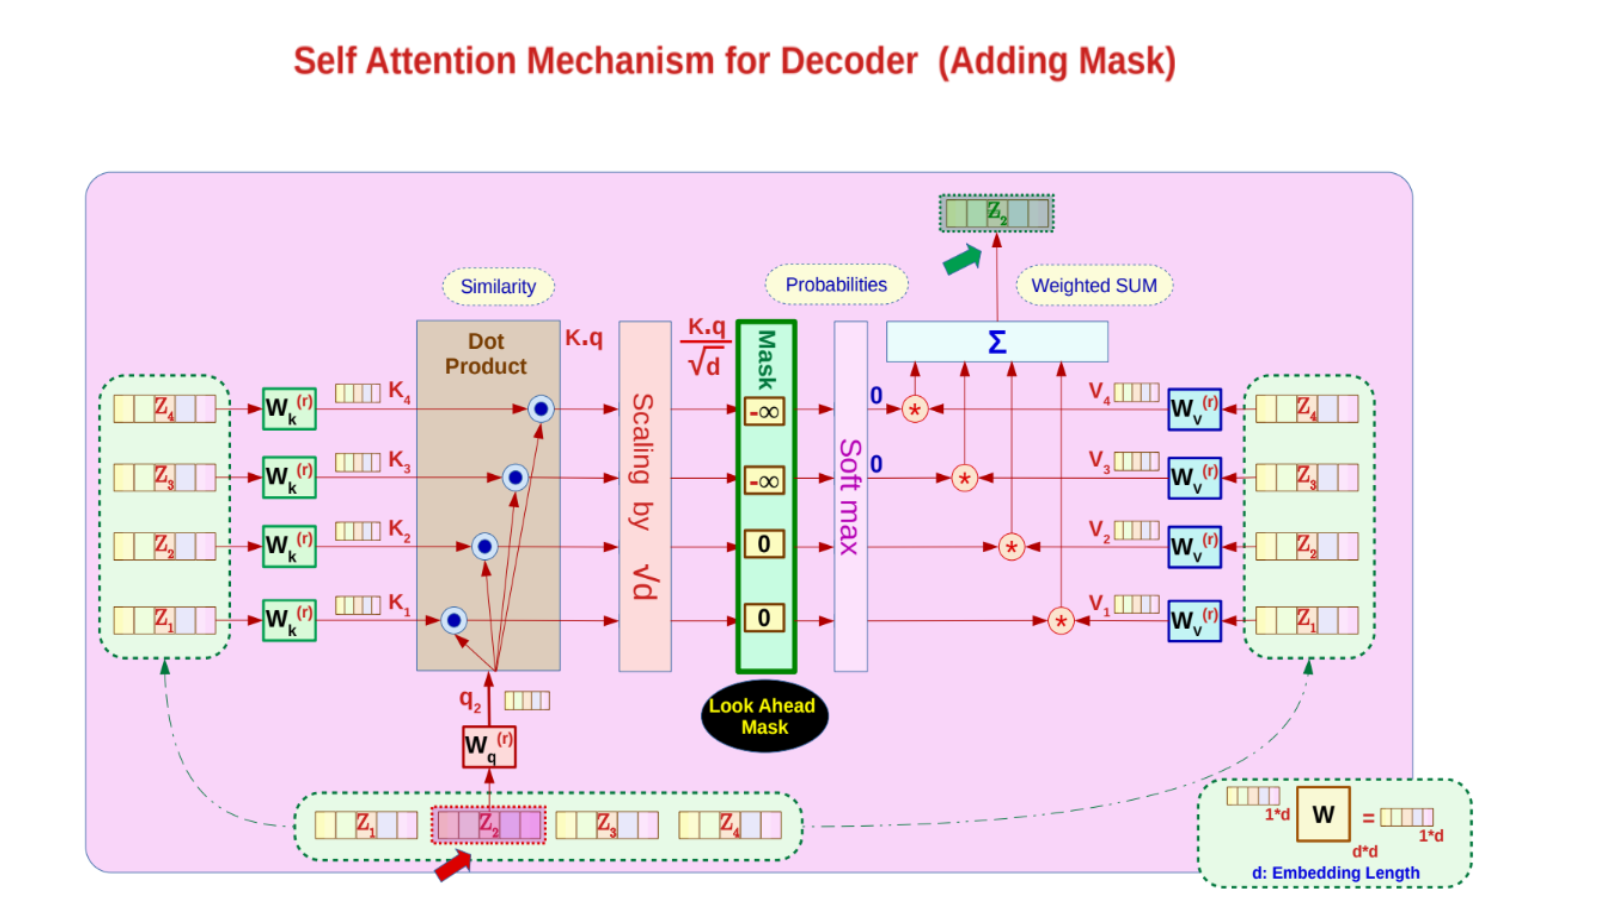

In [9]:
class MaskedMultiHeadAttention(nn.Module):
    def __init__(self, vector_dim, output_dim, num_heads):
        super(MaskedMultiHeadAttention, self).__init__()

        self.vector_dim = vector_dim    # Dimension of input embeddings
        self.output_dim = output_dim    # Dimension of Q, K, V, and final output
        self.num_heads = num_heads
        self.head_dim = output_dim // num_heads  # Dimension per head

        # Linear projections
        self.query = nn.Linear(vector_dim, output_dim)
        self.key   = nn.Linear(vector_dim, output_dim)
        self.value = nn.Linear(vector_dim, output_dim)

        # Final output projection
        self.out_proj = nn.Linear(output_dim, output_dim)

        # Causal mask: upper-triangular matrix filled with -inf (except diagonal and below)
        self.register_buffer("causal_mask", torch.tril(torch.ones(1000, 1000)).unsqueeze(0).unsqueeze(0))  # (1, 1, max_context, max_context)

    def forward(self, x):
        Batch, context_size, _ = x.shape  # (Batch, context_size, vector_dim)

        # Linear projections: (Batch, context_size, vector_dim) * (vector_dim, output_dim) = (Batch, context_size, output_dim)
        Queries = self.query(x)
        Keys    = self.key(x)
        Values  = self.value(x)

        # Reshape: (Batch, context_size, output_dim) → (Batch, context_size, num_heads, head_dim)
        Queries = Queries.view(Batch, context_size, self.num_heads, self.head_dim)
        Keys    = Keys.view(Batch, context_size, self.num_heads, self.head_dim)
        Values  = Values.view(Batch, context_size, self.num_heads, self.head_dim)

        # Transpose to (Batch, num_heads, context_size, head_dim)
        Queries = Queries.transpose(1, 2)
        Keys    = Keys.transpose(1, 2)
        Values  = Values.transpose(1, 2)

        # Compute attention scores: (Batch, num_heads, context_size, head_dim) * (Batch, num_heads, head_dim, context_size) = (Batch, num_heads, context_size, context_size)
        AttentionScores = torch.matmul(Queries, Keys.transpose(-2, -1))

        # Apply causal mask: (Batch, num_heads, context_size, context_size)
        mask = self.causal_mask[:, :, :context_size, :context_size]  # crop mask to match context_size
        AttentionScores = AttentionScores.masked_fill(mask == 0, float('-inf'))

        # Scale and apply softmax
        AttentionWeights = F.softmax(AttentionScores / (self.head_dim ** 0.5), dim=-1)

        # Weighted sum: (Batch, num_heads, context_size, context_size) * (Batch, num_heads, context_size, head_dim) = (Batch, num_heads, context_size, head_dim)
        Context = torch.matmul(AttentionWeights, Values)

        # Transpose back: (Batch, context_size, num_heads, head_dim)
        Context = Context.transpose(1, 2)

        # Concatenate heads: (Batch, context_size, num_heads * head_dim) = (Batch, context_size, output_dim)
        Context = Context.contiguous().view(Batch, context_size, self.output_dim)

        # Final output projection
        Output = self.out_proj(Context)  # (Batch, context_size, output_dim)

        return Output

# 3. Transformer Block

## 3.1. Layer Normalization

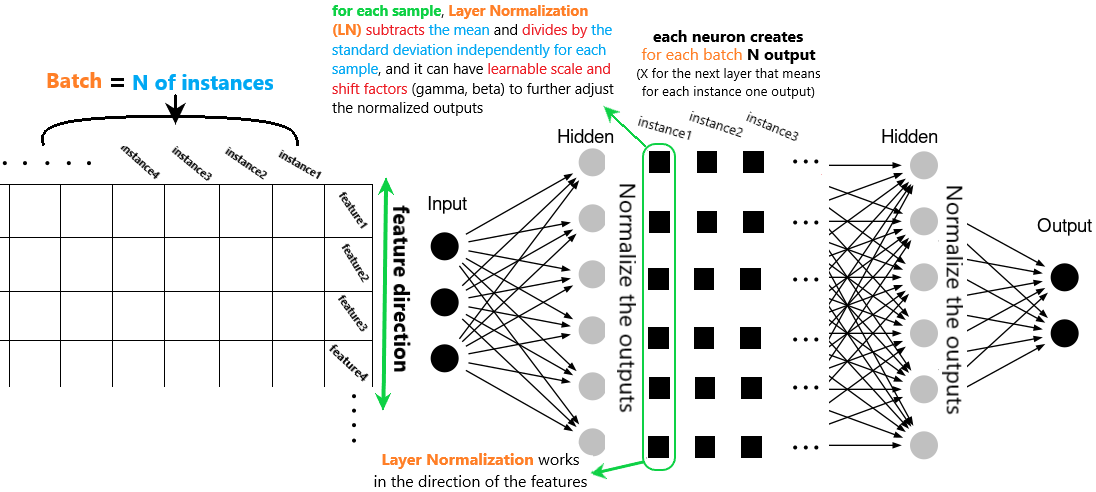

In [11]:
class LayerNorm(nn.Module):
  def __init__(self, vecotr_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(vecotr_dim))
    self.shift = nn.Parameter(torch.zeros(vecotr_dim))

  def forward(self, x):
    mean = x.mean(dim = -1, keepdim = True)
    std = x.std(dim = -1, keepdim = True)
    norm_x = (x - mean) / (std + self.eps)

    return self.scale * norm_x + self.shift # This allows the model to learn appropriate scaling and shifting that best suit the data

## 3.2. Gelu activation function

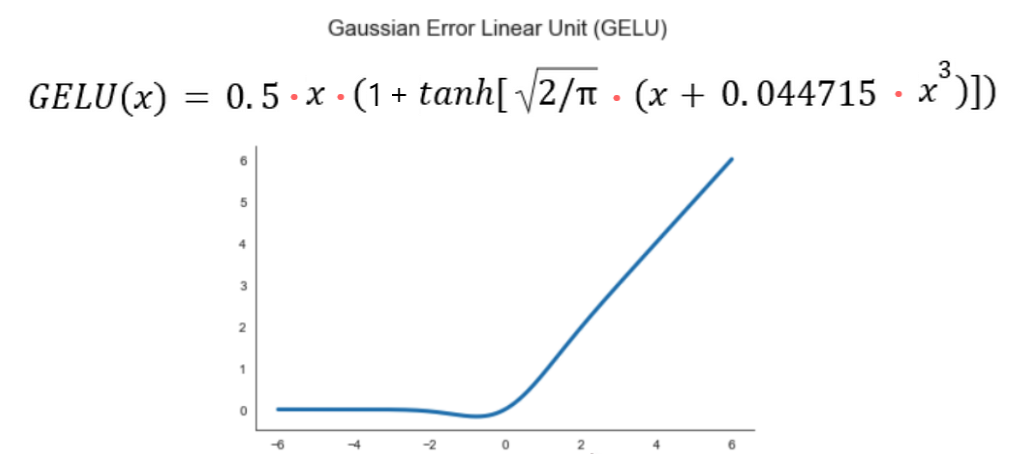

In [12]:
class Gelu(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2 / torch.pi)) *
             (x + 0.044715 * torch.pow(x, 3))
             )
          )

## 3.3. Feedforward network

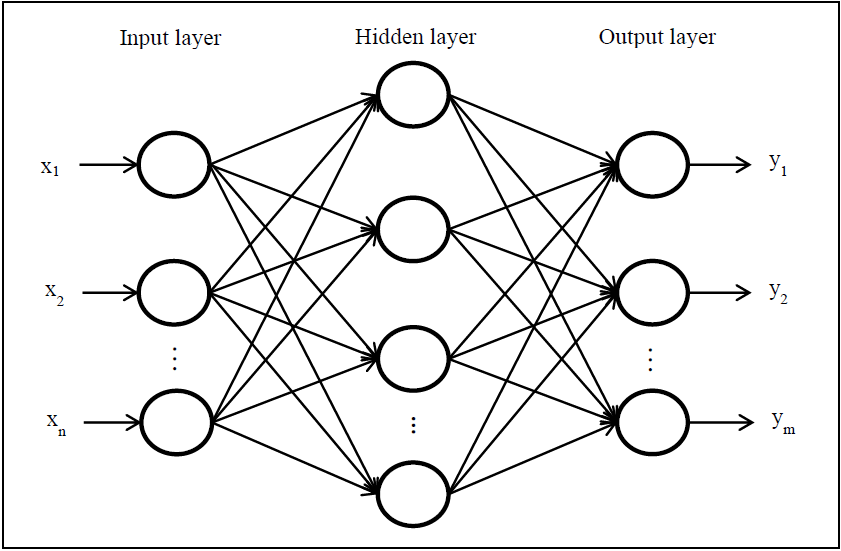

In [13]:
class FeedForward(nn.Module):
  def __init__(self, vector_dim):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(vector_dim, 4 * vector_dim),
        Gelu(),
        nn.Linear(4 * vector_dim, vector_dim),
    )

  def forward(self, x):
    return self.net(x)

## 3.4. Full architecture

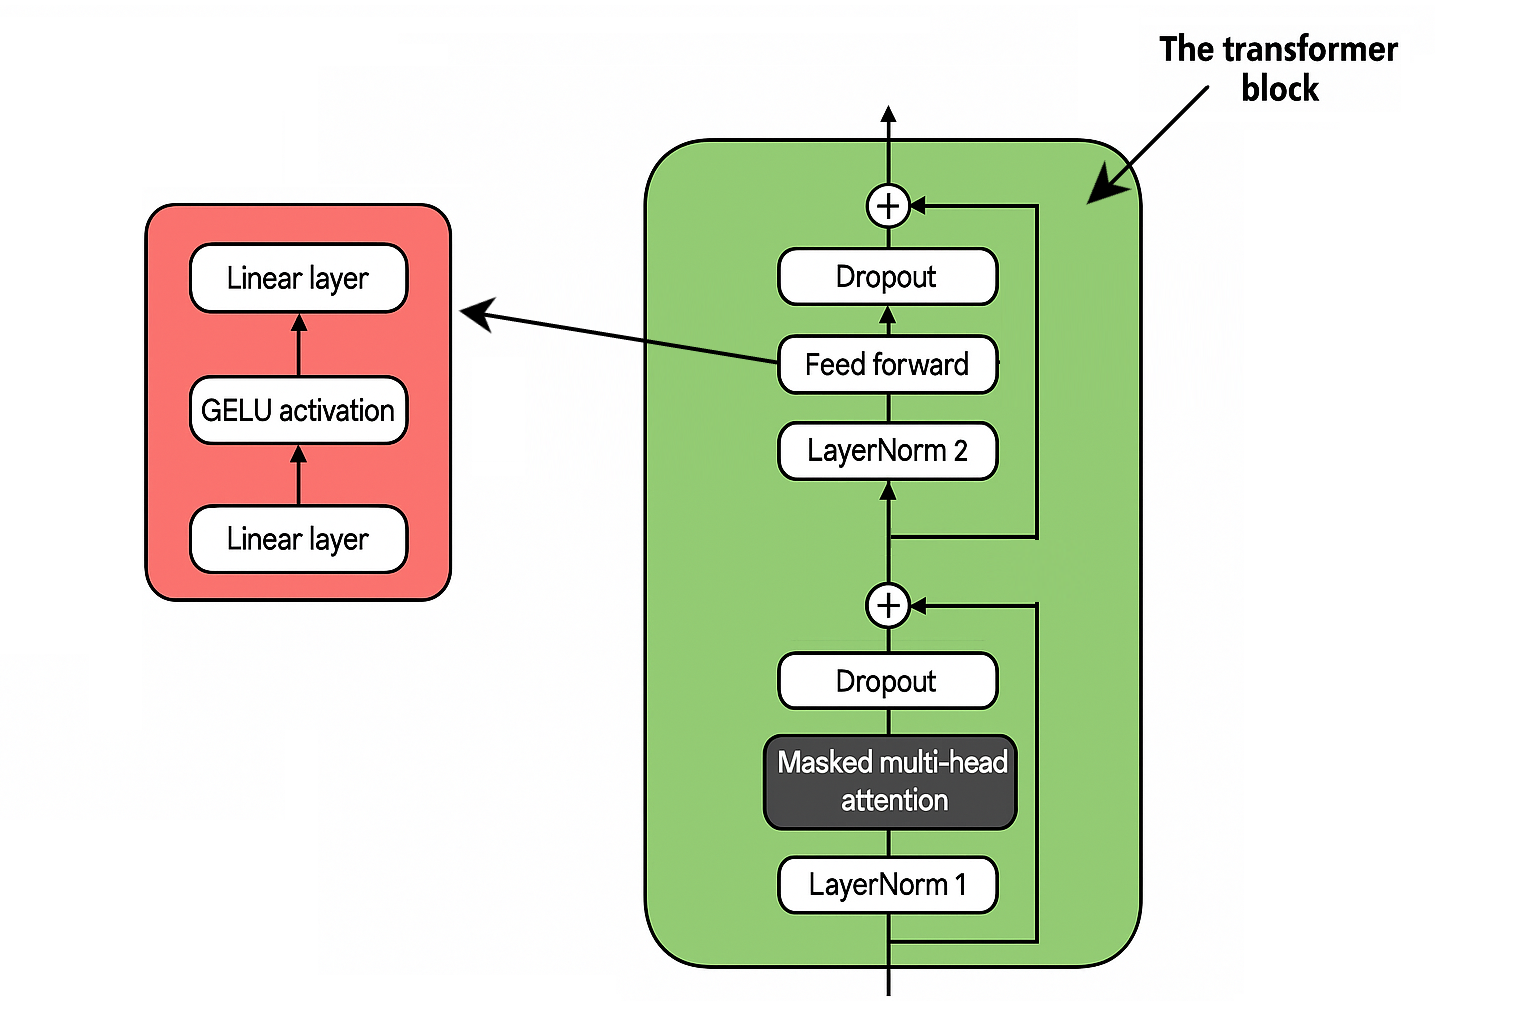

In [20]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super(TransformerBlock, self).__init__()

    # Attention block
    self.Normlayer1 = LayerNorm(cfg["vector_dimension"])  # First norm layer
    # Masked multi-head attenstion
    self.multihead_att = MaskedMultiHeadAttention(cfg["vector_dimension"], cfg["vector_dimension"], cfg["num_heads_per_attention_layer"])
    self.dropout1 = nn.Dropout(cfg["drop_rate"])  # First dropout layer

    # feedforward block
    self.Normlayer2 = LayerNorm(cfg["vector_dimension"])  # Second norm layer
    self.feedforward = FeedForward(cfg["vector_dimension"])  # Feedforward layer
    self.dropout2 = nn.Dropout(cfg["drop_rate"])  # Second dropout layer

  def forward(self, x):

    # Shortcut connection for attention block
    shortcut = self.Normlayer1(x)
    x = self.multihead_att(x)
    x = self.dropout1(x)
    x = x + shortcut

    # shortcut connection for feed forward block
    shortcut = self.Normlayer2(x)
    x = self.feedforward(x)
    x = self.dropout2(x)
    return x + shortcut


In [22]:
Trans_block = TransformerBlock(cfg)
out = Trans_block.forward(position_encoded_values)
print(out.shape)
print(out[:2, :, :10])

torch.Size([8, 5, 100])
tensor([[[ 1.4638,  1.8758,  0.1923,  0.5990,  0.1219,  0.0995, -0.4325,
          -0.3320,  0.1874, -2.3330],
         [-0.3147,  0.6946, -0.2679,  1.9103, -1.0331, -0.5712, -0.9984,
          -1.5781,  0.5871,  0.1871],
         [ 0.3677, -0.6046, -0.4617, -0.7648, -0.6740, -0.5309, -0.6525,
          -1.7767, -1.6864, -1.1759],
         [-0.1294,  0.4003, -0.5161,  0.9397,  1.1556, -0.1388,  1.5657,
          -1.4678, -0.4585,  1.6197],
         [-0.1879,  0.9712,  0.2589,  0.8201, -0.0450, -1.3269,  0.0174,
           0.1824,  1.4887, -1.3984]],

        [[ 0.4624,  2.2921,  0.9067,  0.9317,  1.3056,  0.4088, -0.5977,
           0.3465,  1.4025, -1.0590],
         [-1.2463,  0.2663, -0.1655,  1.2139, -2.3287,  0.0777, -0.3520,
          -2.8137,  0.2914, -0.7306],
         [-0.3717,  0.8393, -1.1070,  0.2275, -0.3413, -1.0081,  0.2761,
          -1.1751, -0.7545, -0.8214],
         [-0.1992, -1.3131, -0.1647,  1.3552,  0.9850, -0.7808,  1.5572,
          -1.

# 4. GPT model

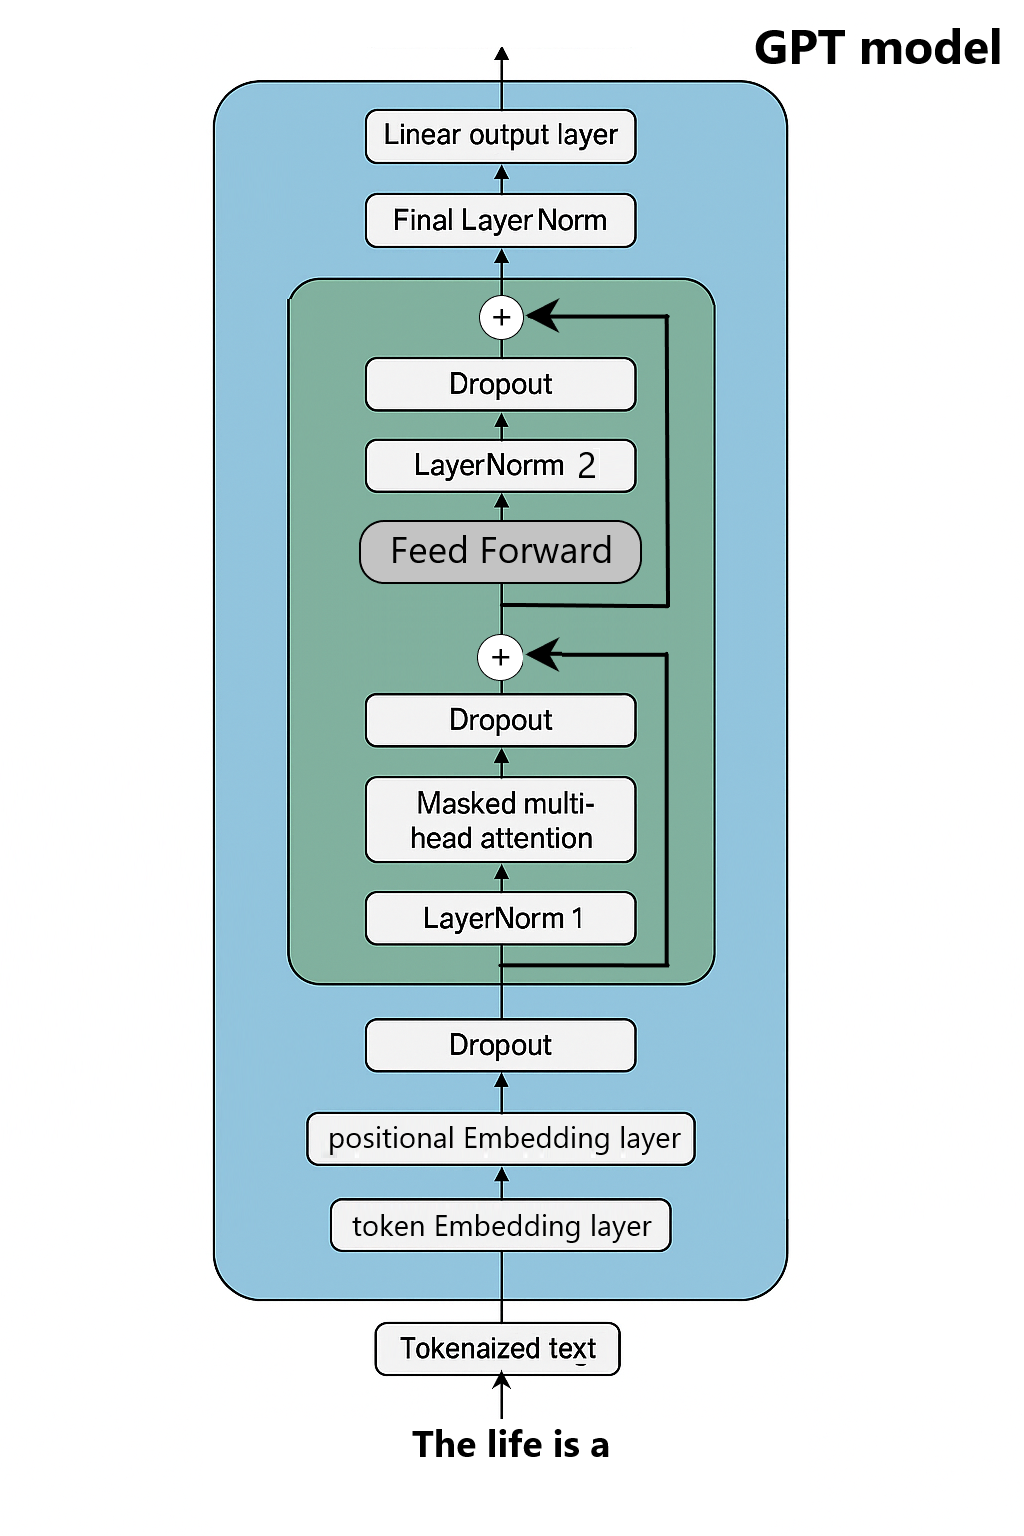

In [ ]:
class GPT(nn.Module):
  def __init__(self, cfg):
    super().__init__()

    self.cfg = cfg
    self.embedding_layer = nn.Embedding(cfg['vocabulary_size'], cfg["vector_dimension"])  # Embedding layer
    self.position_layer = nn.Embedding(cfg["context_size"], cfg["vector_dimension"])  # Positional Embedding Layer

    self.drop_out = nn.Dropout(cfg["drop_rate"])

    self.transformerblock = TransformerBlock(cfg)

    self.norm_layer = LayerNorm(cfg["vector_dimension"])

    self.output_layer = nn.Linear(cfg["vector_dimension"], cfg["vocabulary_size"])

  def forward(self, x):

    embedding = self.embedding_layer(x_batch)  # Get batch Embedding
    position_emb = self.position_layer(torch.arange(self.cfg["context_size"]))  # Generate position indices: shape (context_size,)
    position_encoded_values = x_token_embedding + position_emb  # Add position encoding

    dropped_x = self.drop_out(position_encoded_values)
    x = self.transformerblock(dropped_x)

    x = self.norm_layer(x)
    logits = self.output_layer(x)

    return logits